# Task 1.2: Geolocation Analysis - IP to Country Mapping

## Objective
Enrich transaction data with geographic information by:
1. Converting IP addresses to integer format
2. Mapping IP addresses to countries using range-based lookup
3. Analyzing fraud patterns by country

## Why Geolocation Matters for Fraud Detection
- Transactions from certain regions may have higher fraud rates
- Mismatches between user location and transaction location can signal fraud
- Geographic velocity (transactions from distant locations in short time) indicates fraud

In [1]:
# Standard imports
import sys
from pathlib import Path

# Add project root to path for imports
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project imports
from src.data.loader import load_fraud_data, load_ip_country_data
from src.data.geo import ip_to_int, ip_series_to_int, merge_ip_to_country, get_country_fraud_stats

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 1. Load Data

In [2]:
# Load cleaned fraud data from previous notebook
CLEANED_DATA_PATH = project_root / "data" / "processed" / "fraud_cleaned.parquet"

# If cleaned data exists, use it; otherwise load raw and clean
if CLEANED_DATA_PATH.exists():
    df_fraud = pd.read_parquet(CLEANED_DATA_PATH)
    print(f"Loaded cleaned data: {df_fraud.shape}")
else:
    from src.data.cleaning import clean_fraud_data
    df_raw = load_fraud_data(project_root / "data" / "raw" / "Fraud_Data.csv")
    df_fraud, _ = clean_fraud_data(df_raw)
    print(f"Loaded and cleaned raw data: {df_fraud.shape}")

Loaded cleaned data: (151112, 11)


In [3]:
# Load IP to country mapping
IP_COUNTRY_PATH = project_root / "data" / "raw" / "IpAddress_to_Country.csv"

df_ip_country = load_ip_country_data(IP_COUNTRY_PATH)
print(f"IP Country mapping shape: {df_ip_country.shape}")
df_ip_country.head()

IP Country mapping shape: (138846, 3)


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## 2. Understand IP Address Format

In [4]:
# Check the format of IP addresses in fraud data
print("IP Address column info:")
print(f"  Data type: {df_fraud['ip_address'].dtype}")
print(f"  Sample values:")
print(df_fraud['ip_address'].head(10))

IP Address column info:
  Data type: float64
  Sample values:
0    7.327584e+08
1    3.503114e+08
2    2.621474e+09
3    3.840542e+09
4    4.155831e+08
5    2.809315e+09
6    3.987484e+09
7    1.692459e+09
8    3.719094e+09
9    3.416747e+08
Name: ip_address, dtype: float64


In [5]:
# Check the format of IP ranges in mapping data
print("\nIP Range column info:")
print(f"  Lower bound dtype: {df_ip_country['lower_bound_ip_address'].dtype}")
print(f"  Upper bound dtype: {df_ip_country['upper_bound_ip_address'].dtype}")
print(f"\nSample IP ranges:")
df_ip_country.head()


IP Range column info:
  Lower bound dtype: float64
  Upper bound dtype: int64

Sample IP ranges:


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [6]:
# Check unique countries
print(f"\nNumber of unique countries: {df_ip_country['country'].nunique()}")
print(f"\nTop 10 countries by IP range count:")
print(df_ip_country['country'].value_counts().head(10))


Number of unique countries: 235

Top 10 countries by IP range count:
country
United States         46868
Canada                 6989
Russian Federation     6739
Australia              6316
Germany                5999
United Kingdom         5401
Brazil                 4885
China                  3725
Poland                 3042
Japan                  3005
Name: count, dtype: int64


In [ ]:
from IPython.display import Markdown, display

ip_dtype = str(df_fraud['ip_address'].dtype)
lb_dtype = str(df_ip_country['lower_bound_ip_address'].dtype)
ub_dtype = str(df_ip_country['upper_bound_ip_address'].dtype)

n_countries = df_ip_country['country'].nunique()

display(
    Markdown(
        f"""
### Interpretation: IP Address Format

- **Transaction `ip_address` dtype**: `{ip_dtype}`.
- **IP range bounds dtype**:
  - `lower_bound_ip_address`: `{lb_dtype}`
  - `upper_bound_ip_address`: `{ub_dtype}`
- **Geographic coverage**: `{n_countries:,}` unique countries available in the mapping table.

**Why we convert IPs**
- The mapping is defined as numeric ranges, so converting transaction IPs to comparable integers is required for a correct range-based join.
"""
    )
)

## 3. IP Address Conversion

In [7]:
# Demonstrate IP to integer conversion
print("IP Conversion Examples:")
test_ips = ["192.168.1.1", "10.0.0.1", "255.255.255.255", 3232235777.0]
for ip in test_ips:
    result = ip_to_int(ip)
    print(f"  {ip} -> {result}")

IP Conversion Examples:
  192.168.1.1 -> 3232235777
  10.0.0.1 -> 167772161
  255.255.255.255 -> 4294967295
  3232235777.0 -> 3232235777


In [8]:
# Convert IP addresses in fraud data to integers
df_fraud['ip_int'] = ip_series_to_int(df_fraud['ip_address'])

print("IP conversion results:")
print(f"  Original column: ip_address")
print(f"  New column: ip_int")
print(f"  Invalid IPs (=-1): {(df_fraud['ip_int'] == -1).sum()}")

df_fraud[['ip_address', 'ip_int']].head(10)

IP conversion results:
  Original column: ip_address
  New column: ip_int
  Invalid IPs (=-1): 0


,ip_address,ip_int
0,7.327584e+08,732758368
1,3.503114e+08,350311387
2,2.621474e+09,2621473820
3,3.840542e+09,3840542443
4,4.155831e+08,415583117
5,2.809315e+09,2809315199
6,3.987484e+09,3987484328
7,1.692459e+09,1692458727
8,3.719094e+09,3719094257
9,3.416747e+08,341674739


## 4. Merge IP to Country

In [9]:
# Perform the range-based merge to add country
df_with_country = merge_ip_to_country(
    df_fraud.drop(columns=['ip_int']),  # Remove temp column, function will recreate
    df_ip_country,
    ip_column='ip_address'
)

print(f"Merged data shape: {df_with_country.shape}")
print(f"New 'country' column added: {'country' in df_with_country.columns}")

Merged data shape: (151112, 12)
New 'country' column added: True


In [10]:
# Check merge results
country_counts = df_with_country['country'].value_counts()
unknown_count = (df_with_country['country'] == 'Unknown').sum()

print(f"Country mapping results:")
print(f"  Total transactions: {len(df_with_country):,}")
print(f"  Mapped to country: {len(df_with_country) - unknown_count:,}")
print(f"  Unknown/Unmapped: {unknown_count:,} ({unknown_count/len(df_with_country)*100:.2f}%)")
print(f"  Unique countries: {df_with_country['country'].nunique()}")

Country mapping results:
  Total transactions: 151,112
  Mapped to country: 129,146
  Unknown/Unmapped: 21,966 (14.54%)
  Unique countries: 182


In [11]:
# Sample of merged data
df_with_country[['ip_address', 'country', 'class']].head(10)

,ip_address,country,class
0,52093.496895,Unknown,0
1,93447.138961,Unknown,0
2,105818.501505,Unknown,0
3,117566.664867,Unknown,0
4,131423.789042,Unknown,0
5,155130.397004,Unknown,0
6,155399.107925,Unknown,0
7,159119.791297,Unknown,0
8,166326.775242,Unknown,0
9,207999.643852,Unknown,0


In [ ]:
from IPython.display import Markdown, display

unknown_count = (df_with_country['country'] == 'Unknown').sum()
mapped_count = len(df_with_country) - unknown_count
mapped_pct = mapped_count / len(df_with_country) * 100

n_countries_tx = df_with_country['country'].nunique()

display(
    Markdown(
        f"""
### Interpretation: IP to Country Merge

- **Successfully mapped**: `{mapped_count:,}` / `{len(df_with_country):,}` transactions (**{mapped_pct:.2f}%**).
- **Unmapped (`Unknown`)**: `{unknown_count:,}` transactions (**{100 - mapped_pct:.2f}%**).
- **Countries present in transactions after merge**: `{n_countries_tx:,}`.

**Assessment**
- A small `Unknown` rate is normal due to incomplete IP coverage or malformed IPs.
- We keep `Unknown` as a valid category so the model can learn whether unmapped IPs correlate with fraud.
"""
    )
)

## 5. Fraud Analysis by Country

In [12]:
# Calculate fraud statistics by country
country_stats = get_country_fraud_stats(df_with_country, target_col='class')

print("Top 15 Countries by Fraud Count:")
display(country_stats.head(15))

Top 15 Countries by Fraud Count:


,country,total_transactions,fraud_count,fraud_rate
0,United States,58049,5551,0.095626
1,Unknown,21966,1883,0.085723
2,China,12038,1043,0.086642
3,Japan,7306,715,0.097865
4,United Kingdom,4490,477,0.106236
5,Korea Republic of,4162,380,0.091302
6,Canada,2975,348,0.116975
7,France,3161,300,0.094907
8,Brazil,2961,270,0.091185
9,Germany,3646,262,0.071860


In [13]:
# Countries with highest fraud rates (with minimum transaction count)
MIN_TRANSACTIONS = 100  # Filter out countries with too few transactions

country_stats_filtered = country_stats[country_stats['total_transactions'] >= MIN_TRANSACTIONS]
top_fraud_rate = country_stats_filtered.sort_values('fraud_rate', ascending=False).head(15)

print(f"\nTop 15 Countries by Fraud Rate (min {MIN_TRANSACTIONS} transactions):")
display(top_fraud_rate)


Top 15 Countries by Fraud Rate (min 100 transactions):


,country,total_transactions,fraud_count,fraud_rate
46,Ecuador,106,28,0.264151
44,Tunisia,118,31,0.262712
43,Peru,119,31,0.260504
29,Ireland,240,55,0.229167
25,New Zealand,278,62,0.223022
31,Saudi Arabia,264,50,0.189394
19,Denmark,490,78,0.159184
24,Chile,417,64,0.153477
42,Greece,231,33,0.142857
52,United Arab Emirates,114,16,0.140351


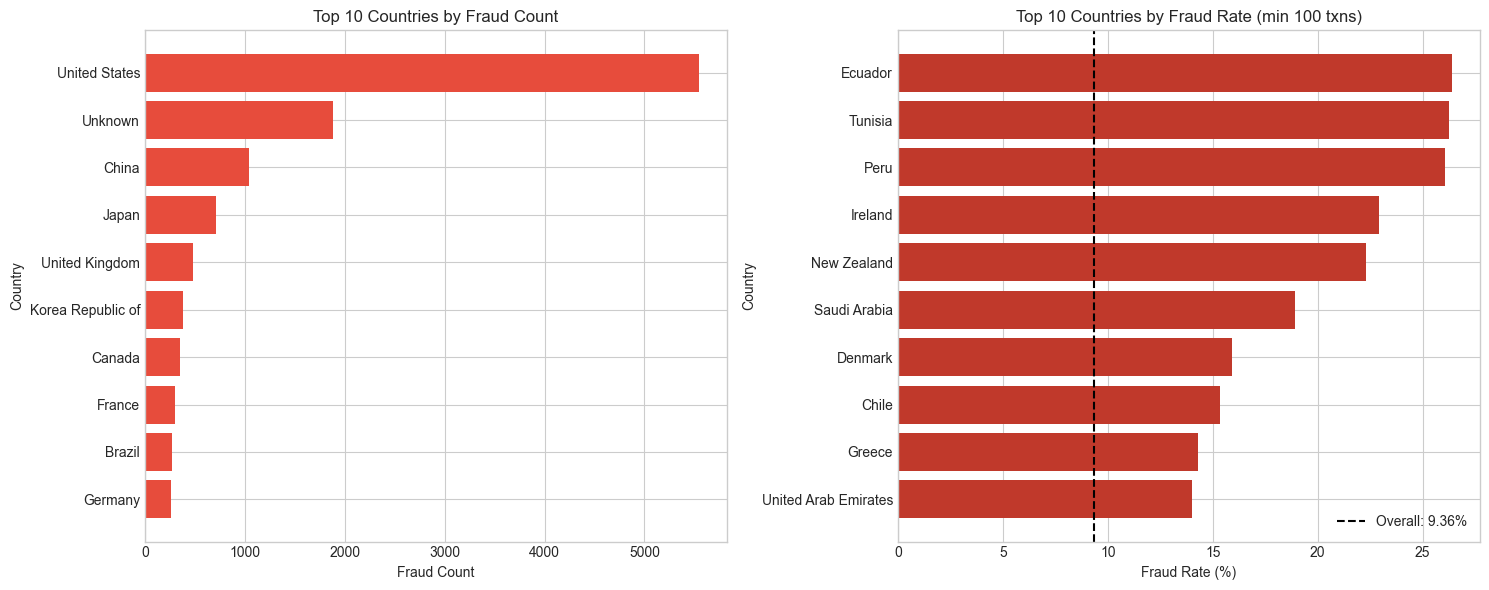

In [14]:
# Visualize fraud by country
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top countries by fraud count
top_by_count = country_stats.head(10)
axes[0].barh(top_by_count['country'], top_by_count['fraud_count'], color='#e74c3c')
axes[0].set_xlabel('Fraud Count')
axes[0].set_ylabel('Country')
axes[0].set_title('Top 10 Countries by Fraud Count')
axes[0].invert_yaxis()

# Top countries by fraud rate (filtered)
top_by_rate = country_stats_filtered.sort_values('fraud_rate', ascending=False).head(10)
axes[1].barh(top_by_rate['country'], top_by_rate['fraud_rate'] * 100, color='#c0392b')
axes[1].set_xlabel('Fraud Rate (%)')
axes[1].set_ylabel('Country')
axes[1].set_title(f'Top 10 Countries by Fraud Rate (min {MIN_TRANSACTIONS} txns)')
axes[1].invert_yaxis()

# Add overall fraud rate line
overall_rate = df_with_country['class'].mean() * 100
axes[1].axvline(x=overall_rate, color='black', linestyle='--', label=f'Overall: {overall_rate:.2f}%')
axes[1].legend()

plt.tight_layout()
plt.show()

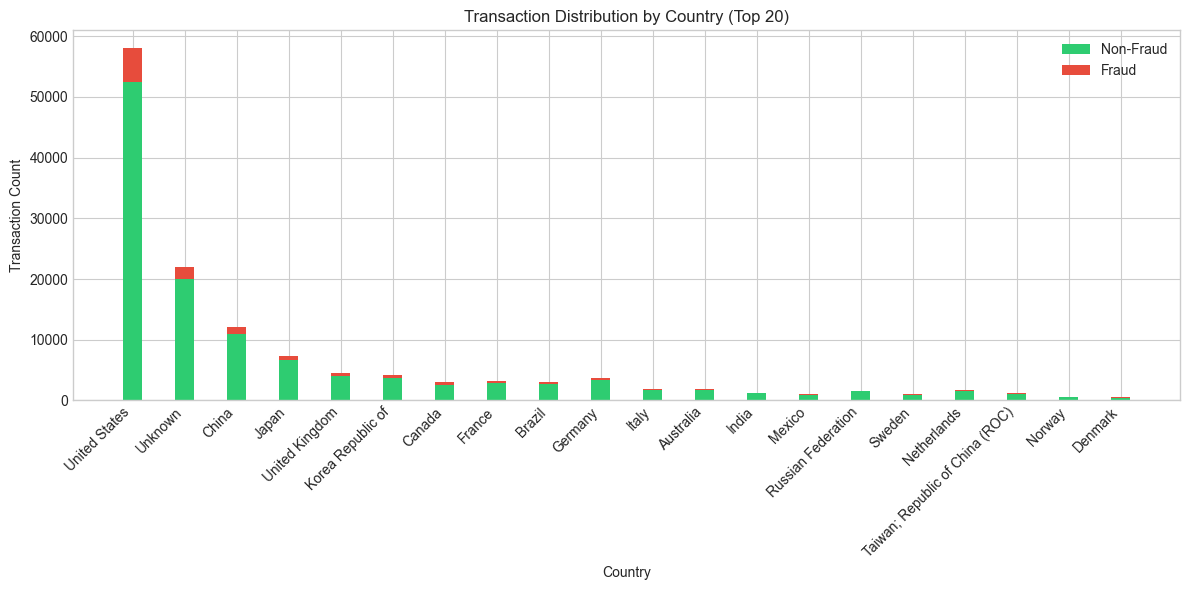

In [15]:
# Transaction distribution by country (top 20)
top_countries = country_stats.head(20)

fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(top_countries))
width = 0.35

non_fraud = top_countries['total_transactions'] - top_countries['fraud_count']
bars1 = ax.bar(x, non_fraud, width, label='Non-Fraud', color='#2ecc71')
bars2 = ax.bar(x, top_countries['fraud_count'], width, bottom=non_fraud, label='Fraud', color='#e74c3c')

ax.set_xlabel('Country')
ax.set_ylabel('Transaction Count')
ax.set_title('Transaction Distribution by Country (Top 20)')
ax.set_xticks(x)
ax.set_xticklabels(top_countries['country'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
from IPython.display import Markdown, display

MIN_TRANSACTIONS = 100
country_stats_filtered = country_stats[country_stats['total_transactions'] >= MIN_TRANSACTIONS]

# Top by fraud count and fraud rate
TopN = 5

top_count = country_stats.head(TopN)
top_rate = country_stats_filtered.sort_values('fraud_rate', ascending=False).head(TopN)

def _fmt_rows(df):
    return "\n".join(
        [
            f"- `{r.country}`: fraud `{int(r.fraud_count):,}` / total `{int(r.total_transactions):,}` (rate `{r.fraud_rate*100:.2f}%`)"
            for r in df.itertuples(index=False)
        ]
    )

display(
    Markdown(
        f"""
### Interpretation: Geographic Fraud Patterns

**Top countries by fraud count**
{_fmt_rows(top_count)}

**Top countries by fraud rate** *(filtered to ≥ {MIN_TRANSACTIONS} transactions to reduce noise)*
{_fmt_rows(top_rate)}

**Business implications (initial)**
- Countries with consistently higher fraud rates may warrant **step-up verification** or **transaction limits**.
- High fraud *count* can indicate exposure/volume; high fraud *rate* is more indicative of risk.

We’ll validate these signals later with model explainability (SHAP) to avoid drawing conclusions from small-sample artifacts.
"""
    )
)

In [ ]:
from IPython.display import Markdown, display

unknown_count = (df_with_country['country'] == 'Unknown').sum()
mapped_pct = (len(df_with_country) - unknown_count) / len(df_with_country) * 100

top_rate = (
    country_stats[country_stats['total_transactions'] >= 100]
    .sort_values('fraud_rate', ascending=False)
    .head(5)
)

top_rate_list = ", ".join([r.country for r in top_rate.itertuples(index=False)])

display(
    Markdown(
        f"""
## 6. Summary and Next Steps

### Key Findings
1. **IP mapping success rate**: `{mapped_pct:.2f}%` of transactions were mapped to a country.
2. **High-risk countries (by rate, min 100 tx)**: {top_rate_list if top_rate_list else "N/A"}.
3. **Geographic patterns**: Fraud distribution differs across countries; this feature is likely useful for segmentation and downstream modeling.

### Business Implications
- Implement **risk-based authentication** for high-risk geographies (e.g., OTP / 3DS / manual review triggers).
- Use country-level risk as an input to real-time scoring, but ensure fairness and monitor drift.

### Next Steps
- Proceed to feature engineering in `03_feature_engineering_fraud.ipynb`.
- Keep `country` (including `Unknown`) as a categorical feature for modeling.
"""
    )
)

In [16]:
# Save data with country for next notebook
output_path = project_root / "data" / "processed" / "fraud_with_country.parquet"
df_with_country.to_parquet(output_path, index=False)
print(f"Data with country saved to: {output_path}")

Data with country saved to: /Users/macbookpro/Documents/Fraud-Detection-system/data/processed/fraud_with_country.parquet
